In [41]:
import os
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense


### Loading Data

In [2]:
# Download the IMDb Large Movie Review Dataset
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

# Extract the downloaded .tar.gz archive
!tar -xzf aclImdb_v1.tar.gz


--2025-04-06 11:47:46--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  17.8MB/s    in 7.3s    

2025-04-06 11:47:53 (11.0 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
# List contents to verify it was extracted properly
!ls aclImdb


imdbEr.txt  imdb.vocab	README	test  train


In [4]:
# Display one sample review from training data (positive)
with open("aclImdb/train/pos/0_9.txt", encoding="utf-8") as f:
    print(f.read())


Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [5]:
def load_imdb_data(directory):
    data = []
    for label in ['pos', 'neg']:
        folder_path = os.path.join(directory, label)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, encoding='utf-8') as f:
                review = f.read()
                sentiment = 1 if label == 'pos' else 0
                data.append((review, sentiment))
    return pd.DataFrame(data, columns=['review', 'sentiment'])

# Load raw training and test data
train_df = load_imdb_data("aclImdb/train")
test_df = load_imdb_data("aclImdb/test")

# Save to CSV files
train_df.to_csv("imdb_train.csv", index=False)
test_df.to_csv("imdb_test.csv", index=False)

print("✅ CSV files created successfully!")


✅ CSV files created successfully!


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [8]:
train_df

,review,sentiment
0,"The performances were superb, the costumes del...",1
1,I was not expecting much from this movie. I wa...,1
2,"Films such as Chocolat, Beau Travail, and othe...",1
3,I've seen The Blob several times and is one of...,1
4,Definitely one of the lesser of the Astaire/Ro...,1
...,...,...
24995,"In Texas, seven friends meet in a bar to celeb...",0
24996,"I seems in the beginning a interesting film, a...",0
24997,I have watched this movie a few times and neve...,0
24998,The screenwriter poorly attempted to re-create...,0


### Data Preprocessing

In [10]:
def clean_text(text):
    # removing HTML tags
    text = re.sub(r"<.*?>", "", text)
    # removing non-letter characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # lowercase
    text = text.lower()
    return text

# Apply cleaning to both train and test datasets
train_df['clean_review'] = train_df['review'].apply(clean_text)
test_df['clean_review'] = test_df['review'].apply(clean_text)

In [12]:
train_df[['review', 'clean_review']].sample(1).values

array([['This picture in 1935 walked away with all kinds of Ocars for Best Director, John Ford, Actor Victor McLaglen and music by Max Seiner. Victor McLaglen,(Gypo Nolan), "Call Out the Marines",\'42, gave an outstanding performance as an Irish rebel who belonged to a rough and tough crowd who were all fighting for a cause and at the same time getting poorer and poorer with plenty of drinking. Gypo Nolan made a bad mistake when he decided to become an informer for his best friend in order to take a trip with his gal to America and a new way of living. Preston Foster, (Don Gallagher),"Guadalcanal Diary",\'43, gave a great supporting role as the leader of the Irish rebellion and was anxious to capture the informer of his group. Gypo Nolan becomes haunted by his betrayal of his friend and begins to feel just like a Judas. Great film for 1935 and wonderful acting by McLaglen, but rather depressing in every aspect of the film.',
        'this picture in  walked away with all kinds of ocars

In [14]:
# Limit vocabulary size to the top 10,000 most frequent words
vocab_size = 10000

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  # OOV: Out Of Vocabulary
tokenizer.fit_on_texts(train_df['clean_review'])

# Convert text to sequences (list of integers)
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_review'])

In [15]:
word_index = tokenizer.word_index
print(f"Number of unique tokens: {len(word_index)}")


Number of unique tokens: 138423


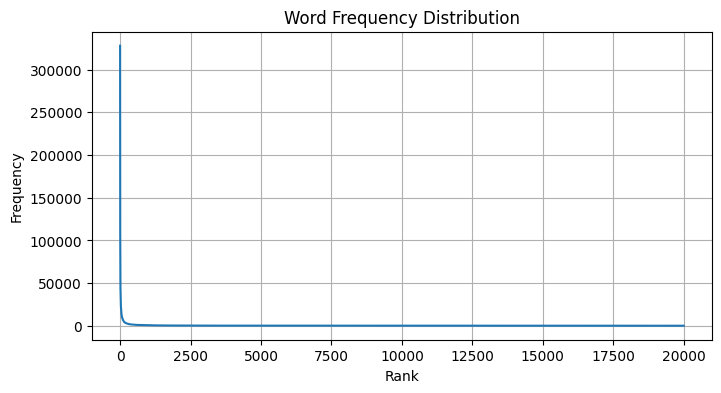

In [22]:
# Word frequency distribution


freqs = list(tokenizer.word_counts.values())
freqs.sort(reverse=True)

plt.figure(figsize=(8, 4))
plt.plot(freqs[:20000])
plt.title("Word Frequency Distribution")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


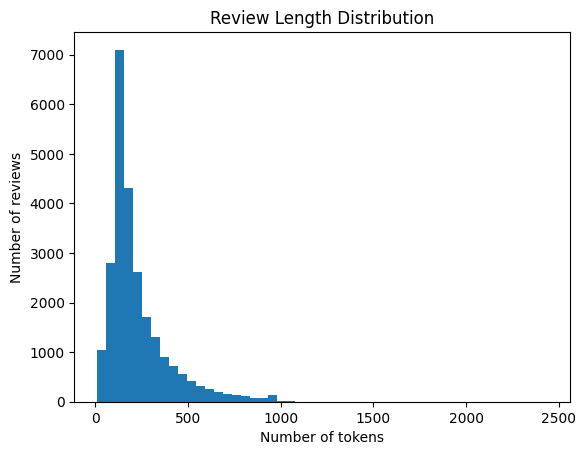

In [23]:
review_lengths = [len(x) for x in X_train_seq]

import matplotlib.pyplot as plt
plt.hist(review_lengths, bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Number of reviews")
plt.show()


In [26]:
# Compute review lengths
train_lengths = [len(seq) for seq in X_train_seq]

# Convert to numpy array for easier stats
lengths_np = np.array(train_lengths)

# Print key statistics
print(f"Min length: {np.min(lengths_np)}")
print(f"Max length: {np.max(lengths_np)}")
print(f"Mean length: {np.mean(lengths_np):.2f}")
print(f"Median length: {np.median(lengths_np)}")
print(f"90th percentile: {np.percentile(lengths_np, 90)}")
print(f"95th percentile: {np.percentile(lengths_np, 95)}")
print(f"99th percentile: {np.percentile(lengths_np, 99)}")

Min length: 10
Max length: 2441
Mean length: 227.74
Median length: 170.0
90th percentile: 446.0
95th percentile: 583.0
99th percentile: 891.0199999999968


In [27]:
# Set max length for reviews, let's go with 300 for now
max_length = 300

# Pad sequences to the same length
X_train = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [32]:
y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

In [28]:
X_train.shape

(25000, 300)

### Modelling

In [30]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=300),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Then use:
history = model.fit(
    X_train_final, y_train_final,
    epochs=5,
    batch_size=128,
    validation_data=(X_val, y_val)
)



Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 88s 559ms/step - accuracy: 0.5352 - loss: 0.6900 - val_accuracy: 0.5702 - val_loss: 0.6430
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 546ms/step - accuracy: 0.5567 - loss: 0.6540 - val_accuracy: 0.5498 - val_loss: 0.6790
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 520ms/step - accuracy: 0.5598 - loss: 0.6591 - val_accuracy: 0.5704 - val_loss: 0.6355
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 546ms/step - accuracy: 0.5782 - loss: 0.6246 - val_accuracy: 0.5872 - val_loss: 0.6240
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 517ms/step - accuracy: 0.6048 - loss: 0.5902 - val_accuracy: 0.7506 - val_loss: 0.5483


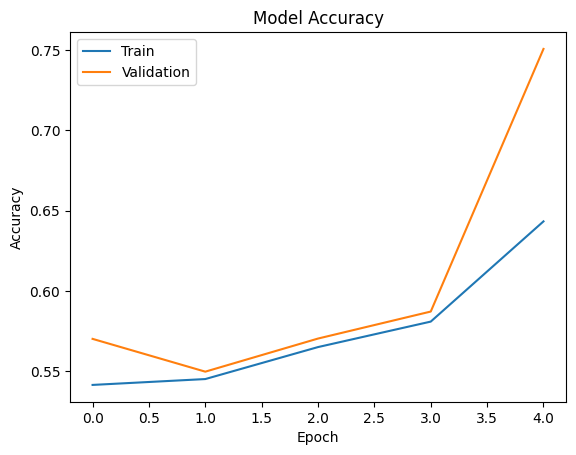

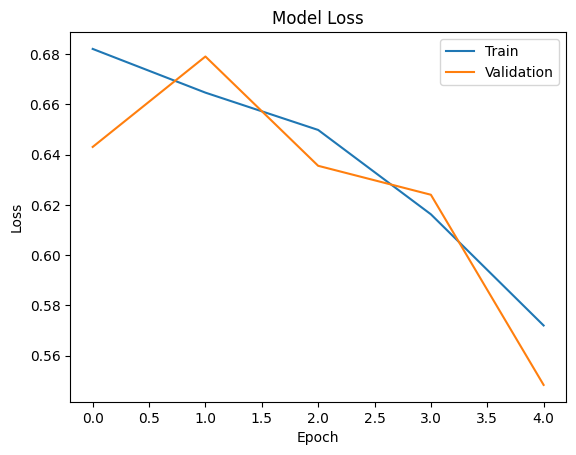

In [37]:

# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Adding dropuut, bidrectional LSTM

In [39]:

model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=300),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop]
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9833 - loss: 0.0576 - val_accuracy: 0.8562 - val_loss: 0.5425
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9832 - loss: 0.0619 - val_accuracy: 0.8460 - val_loss: 0.5849
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9845 - loss: 0.0567 - val_accuracy: 0.8272 - val_loss: 0.5666


### add GloVe embeddings

In [43]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-04-06 14:18:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-06 14:18:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-06 14:18:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [44]:
embedding_index = {}

with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [45]:
embedding_dim = 100
word_index = tokenizer.word_index

embedding_matrix = np.zeros((10000, embedding_dim))

for word, i in word_index.items():
    if i < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [46]:
model = Sequential([
    Embedding(input_dim=10000,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=300,
              trainable=False),  # freeze GloVe weights
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [47]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 160s 992ms/step - accuracy: 0.5863 - loss: 0.6680 - val_accuracy: 0.5742 - val_loss: 0.6782
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 154s 982ms/step - accuracy: 0.6188 - loss: 0.6551 - val_accuracy: 0.6026 - val_loss: 0.6699
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 193s 927ms/step - accuracy: 0.6146 - loss: 0.6565 - val_accuracy: 0.6814 - val_loss: 0.6138
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 212s 989ms/step - accuracy: 0.6528 - loss: 0.6351 - val_accuracy: 0.7500 - val_loss: 0.5376
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 153s 977ms/step - accuracy: 0.7610 - loss: 0.5183 - val_accuracy: 0.8070 - val_loss: 0.4503
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 202s 976ms/step - accuracy: 0.8060 - loss: 0.4490 - val_accuracy: 0.7972 - val_loss: 0.4401
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 203s 983ms/step - accuracy: 0.8070 - loss: 0.4287 - val_accuracy: 0.8216 - val_loss: 0.4049
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 197s 951ms/step - accuracy: 0.8242 -

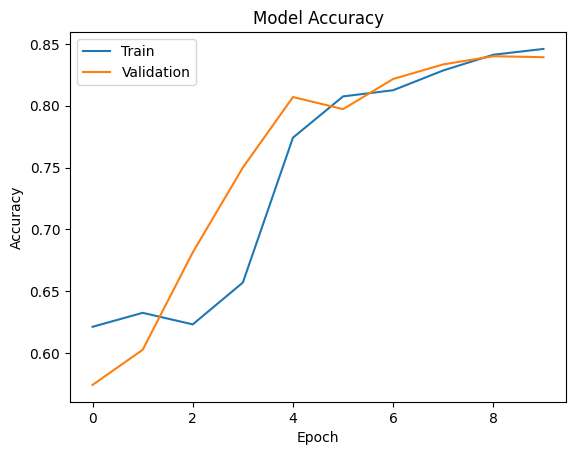

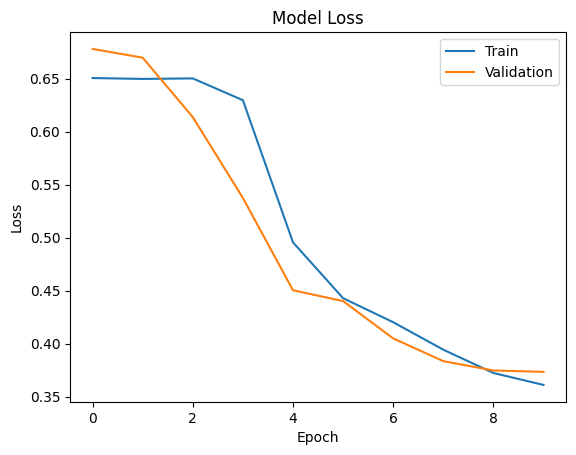

In [48]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
